In [145]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

In [146]:
# Loading pipeline params.
DATA_PATH = Path('data')
FILENAME_STOP = 'stop_90_diff_quat.csv'
FILENAME_0 = '0_90_diff_quat.csv'
FILENAME_90 = '90_90_diff_quat.csv'
FILENAME_180 = '180_90_diff_quat.csv'
FILENAME_270 = '270_90_diff_quat.csv'

# # Loading pipeline params.
# DATA_PATH = Path('data')
# FILENAME_STOP = 'stop.csv'
# FILENAME_0 = 'm_0.csv'
# FILENAME_90 = 'm_90.csv'
# FILENAME_180 = 'm_180.csv'
# FILENAME_270 = 'm_270.csv'


NUM_TIMESTEPS = 6
IGNORE_FRACTION = 0.1
TEST_FRACTION = 0.25

# Training params.
LEARNING_RATE = 1e-5
EPOCHS = 100
BATCH_SIZE = 512

In [147]:
def load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    num_timesteps,
    ignore_fraction,
    test_fraction,
):

    def read_and_prepare_data(
        path,
        class_,
        num_timesteps,
        ignore_fraction,
        test_fraction,
    ):

        def split_temporally(X, test_fraction):
            num_samples = X.shape[0]
            num_train = int(num_samples * (1.0 - test_fraction))
            X_train, X_test = X[:num_train], X[num_train:]
            return X_train, X_test

        def transform_into_sequences(X, num_timesteps):
            num_samples = X.shape[0]
            X_seq = []
            for k in range(num_samples - num_timesteps + 1):
                X_seq.append(X[k:(k + num_timesteps)])
            X_seq = np.array(X_seq)
            y_seq = class_ * np.ones((X_seq.shape[0], 1))
            return X_seq, y_seq

        X = pd.read_csv(path).values
        X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]  # Use only feet translations.

        # Ignore beginning and end.
        num_samples = X.shape[0]
        num_ignore = int(ignore_fraction * num_samples)
        X = X[num_ignore:-num_ignore]

        # Split X temporally.
        X_train, X_test = split_temporally(X, test_fraction)

        # Transform X into short sequences.
        X_train, y_train = transform_into_sequences(X_train, num_timesteps)
        X_test, y_test = transform_into_sequences(X_test, num_timesteps)

        return X_train, y_train, X_test, y_test

    def shuffle_data(X, y):
        idx = np.arange(len(X))
        default_rng().shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx]
        return X_shuffled, y_shuffled

    X_train_stop, y_train_stop, X_test_stop, y_test_stop = \
        read_and_prepare_data(
            path_stop,
            0.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_0, y_train_0, X_test_0, y_test_0 = \
        read_and_prepare_data(
            path_0,
            1.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train_90, y_train_90, X_test_90, y_test_90 = \
        read_and_prepare_data(
            path_90,
            2.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_180, y_train_180, X_test_180, y_test_180 = \
        read_and_prepare_data(
            path_180,
            3.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_270, y_train_270, X_test_270, y_test_270 = \
        read_and_prepare_data(
            path_270,
            4.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train = np.concatenate((X_train_stop, X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
    y_train = np.concatenate((y_train_stop, y_train_0, y_train_90, y_train_180, y_train_270), axis=0)
    X_test = np.concatenate((X_test_stop, X_test_0, X_test_90, X_test_180, X_test_270), axis=0)
    y_test = np.concatenate((y_test_stop, y_test_0, y_test_90, y_test_180, y_test_270), axis=0)

    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)

    return X_train, X_test, y_train, y_test


path_stop = Path(DATA_PATH, FILENAME_STOP)
path_0 = Path(DATA_PATH, FILENAME_0)
path_90 = Path(DATA_PATH, FILENAME_90)
path_180 = Path(DATA_PATH, FILENAME_180)
path_270 = Path(DATA_PATH, FILENAME_270)

X_train, X_test, y_train, y_test = load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    NUM_TIMESTEPS,
    IGNORE_FRACTION,
    TEST_FRACTION,
)

In [148]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100773, 6, 14), (100773, 1), (33575, 6, 14), (33575, 1))

In [149]:
X_test[60].shape


(6, 14)

In [167]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

CNN = Sequential(name="Sequential_CNN")

CNN.add(Conv2D(256, kernel_size=(3, 3),
               strides=(1, 1), padding="same",
               activation="selu", input_shape=[6, 14, 1]))

CNN.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                     padding="valid"))

# Add another pair of Conv2D and MaxPooling2D for more model depth,
# followed by the flatten and multiple dense layers

# CNN.add(Conv2D(64, kernel_size=(3, 3),
#                strides=(1, 1), padding="same",
#                activation="selu"))

# CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
#                      padding="valid"))

CNN.add(Flatten())

CNN.add(Dense(64, activation='selu'))
CNN.add(Dense(32, activation='selu'))
CNN.add(Dense(5, activation='softmax'))

CNN.summary()

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 6, 14, 256)        2560      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 2, 6, 256)        0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 3072)              0         
                                                                 
 dense_60 (Dense)            (None, 64)                196672    
                                                                 
 dense_61 (Dense)            (None, 32)                2080      
                                                                 
 dense_62 (Dense)            (None, 5)                 165       
                                                    

In [168]:
from numpy import *
where_are_NaNsx = isnan(X_train)
X_train[where_are_NaNsx] = 0

where_are_NaNsy = isnan(y_train)
y_train[where_are_NaNsy] = 0

where_are_NaNsxt = isnan(X_test)
X_test[where_are_NaNsxt] = 0

where_are_NaNsyt = isnan(y_test)
y_test[where_are_NaNsyt] = 0

In [169]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = CNN.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=256,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/100
394/394 [==============================] - 22s 56ms/step - loss: 0.2538 - accuracy: 0.9072 - val_loss: 1.9517 - val_accuracy: 0.6923
Epoch 2/100
394/394 [==============================] - 22s 56ms/step - loss: 0.0805 - accuracy: 0.9804 - val_loss: 1.9976 - val_accuracy: 0.6958
Epoch 3/100
394/394 [==============================] - 22s 55ms/step - loss: 0.0664 - accuracy: 0.9834 - val_loss: 2.1866 - val_accuracy: 0.6911
Epoch 4/100
394/394 [==============================] - 22s 55ms/step - loss: 0.0571 - accuracy: 0.9861 - val_loss: 2.8450 - val_accuracy: 0.6899
Epoch 5/100
394/394 [==============================] - 22s 57ms/step - loss: 0.0540 - accuracy: 0.9870 - val_loss: 2.3211 - val_accuracy: 0.6897
Epoch 6/100
394/394 [==============================] - 22s 56ms/step - loss: 0.0537 - accuracy: 0.9867 - val_loss: 2.1025 - val_accuracy: 0.6962
Epoch 7/100
394/394 [==============================] - 23s 57ms/step - loss: 0.0575 - accuracy: 0.9852 - val_loss: 2.2149 - val_ac

394/394 [==============================] - 23s 58ms/step - loss: 0.0217 - accuracy: 0.9943 - val_loss: 8.7432 - val_accuracy: 0.6910
Epoch 58/100
394/394 [==============================] - 23s 58ms/step - loss: 0.0224 - accuracy: 0.9941 - val_loss: 7.8743 - val_accuracy: 0.6958
Epoch 59/100
394/394 [==============================] - 23s 59ms/step - loss: 0.0211 - accuracy: 0.9945 - val_loss: 9.9566 - val_accuracy: 0.6874
Epoch 60/100
394/394 [==============================] - 23s 57ms/step - loss: 0.0220 - accuracy: 0.9942 - val_loss: 10.4986 - val_accuracy: 0.6881
Epoch 61/100
394/394 [==============================] - 23s 59ms/step - loss: 0.0232 - accuracy: 0.9937 - val_loss: 9.1292 - val_accuracy: 0.6887
Epoch 62/100
394/394 [==============================] - 23s 59ms/step - loss: 0.0224 - accuracy: 0.9941 - val_loss: 8.7926 - val_accuracy: 0.6942
Epoch 63/100
394/394 [==============================] - 24s 60ms/step - loss: 0.0207 - accuracy: 0.9944 - val_loss: 9.9634 - val_accurac

In [170]:
# from functools import partial



# _, num_time, num_feat = X_train.shape

# activation = 'selu'

# DefaultConv1D = partial(
#     keras.layers.Conv1D,
#     kernel_size=1,
#     activation=activation,
#     padding="valid",
# )

# model = keras.models.Sequential([
#     DefaultConv1D(4 * num_feat, kernel_size=2, input_shape=[num_time, num_feat]),
#     keras.layers.BatchNormalization(),
#     DefaultConv1D(num_feat, kernel_size=2),
#     keras.layers.Flatten(),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_time * num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(5, activation='softmax'),
# ])

# optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=optimizer,
#     metrics=['accuracy'],
# )

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_test, y_test),
#     verbose=1,
# )

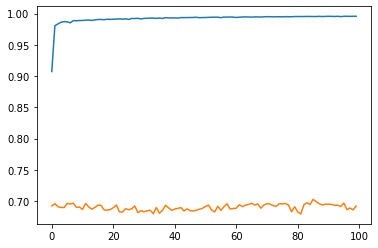

In [171]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

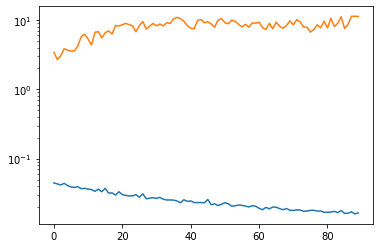

In [172]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.yscale('log')

In [173]:
y_pred = CNN.predict(X_test)

1050/1050 [==============================] - 3s 3ms/step


In [174]:
y_pred

array([[9.3422718e-17, 7.9088127e-23, 1.6118075e-37, 1.9325256e-32,
        1.0000000e+00],
       [1.1884040e-15, 2.5733334e-22, 1.9511796e-30, 6.6525110e-27,
        1.0000000e+00],
       [8.0629307e-01, 8.8372991e-07, 3.5129901e-29, 1.4070981e-18,
        1.9370605e-01],
       ...,
       [9.9998796e-01, 2.5313713e-07, 9.7927898e-07, 1.0873576e-05,
        1.3803232e-09],
       [2.8273361e-03, 3.4455301e-09, 9.9713433e-01, 3.8214635e-05,
        9.7941546e-17],
       [1.3140510e-27, 1.0286960e-33, 0.0000000e+00, 5.9061072e-35,
        1.0000000e+00]], dtype=float32)

In [175]:
y_pred= np.argmax(y_pred, axis=1)

In [176]:
y_pred

array([4, 4, 0, ..., 0, 2, 4])

In [177]:
y_pred[0]

4

In [178]:
df = pd.DataFrame({
    'y_test': y_test.ravel().astype(int).tolist(),
    'y_pred': y_pred.ravel().astype(int).tolist(),
})

In [179]:
pd.crosstab(df['y_test'], df['y_pred'])

y_pred,0,1,2,3,4
y_test,,,,,
0,4197,0,0,47,10151
1,64,4729,1,0,1
2,50,0,4745,0,0
3,24,0,0,4771,0
4,0,0,0,0,4795


In [180]:
# model.save('model.h5')

In [182]:
CNN.save('model_funcional_4_direcoes_19_01_2023.h5')